# IMPORTING LIBRARIES

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import io
import os
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sns

In [ ]:
# I have Uploaded the Data set in the form of CSV file which i will attach.

In [2]:
df = pd.read_csv('BLOG.csv',delimiter=',',encoding='latin-1')
df.head()

,BLOG,GENDER
0,Beyond Getting There: What Travel Days Show U...,F
1,I remember so much about the island; the large...,F
2,I have had asthma and allergies my entire life...,M
3,The last few days have been an emotional rolle...,M
4,If you lined up all the teachers and staff in ...,F


# DATA EXPLORATION

In [3]:
df.groupby('GENDER').describe()

BLOG                                                               
       count unique                                                top freq
GENDER                                                                     
F       1300   1294   W elcome to the February 28, 2010 edition of ...    2
M       1299   1294  Welcome to Grade 1: "Alright students, what do...    3

In [4]:
df['GENDER'].value_counts()

F    1300
M    1300
Name: GENDER, dtype: int64

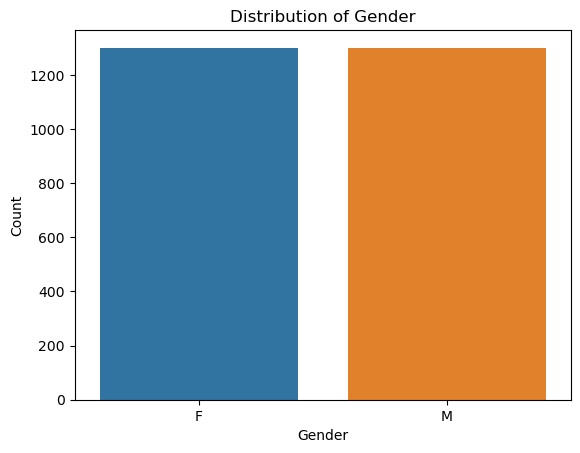

In [6]:
sns.countplot(data=df, x='GENDER')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Distribution of Gender')
plt.show()

# Data CLeaning

In [7]:
df.isnull().value_counts()

BLOG   GENDER
False  False     2599
True   False        1
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.isnull().value_counts()

BLOG   GENDER
False  False     2599
dtype: int64

In [10]:
df_balanced=df

In [13]:
df_balanced['GENDER'].value_counts()

F    1300
M    1299
Name: GENDER, dtype: int64

In [14]:
df_balanced['M']=df_balanced['GENDER'].apply(lambda x: 1 if x=='M' else 0)
df_balanced.sample(5)

,BLOG,GENDER,M
431,passionate. a Christ follower. a hopeless roma...,F,0
44,"This afternoon I sat by the side of the road, ...",M,1
2438,It was Michael Muthu who had suggested Moulin ...,M,1
1290,We'd arranged for Sam to come home today for a...,M,1
135,As much as I liked - but didn't necessarily lo...,M,1


# TEST-TRAIN SPILT DATA

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_balanced['BLOG'],df_balanced['M'], stratify=df_balanced['M'])

In [16]:
X_train.head(4)

2425    What is Google Buzz for? As with any social ne...
1853    Obama confidante and senior adviser David Axel...
490     So I had another odd dream.....\n\nI enter som...
1405    From the customers perspective, its all the ...
Name: BLOG, dtype: object

# Import BERT model

In [17]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [18]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

# Build Model

In [19]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [21]:
len(X_train)

1949

In [22]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

# TRAINING THE MODEL

In [23]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
61/61 [==============================] - 299s 5s/step - loss: 0.6961 - accuracy: 0.5290 - precision: 0.5300 - recall: 0.5082
Epoch 2/10
61/61 [==============================] - 301s 5s/step - loss: 0.6773 - accuracy: 0.5716 - precision: 0.5713 - recall: 0.5719
Epoch 3/10
61/61 [==============================] - 356s 6s/step - loss: 0.6665 - accuracy: 0.5962 - precision: 0.6047 - recall: 0.5544
Epoch 4/10
61/61 [==============================] - 398s 7s/step - loss: 0.6577 - accuracy: 0.6208 - precision: 0.6304 - recall: 0.5832
Epoch 5/10
61/61 [==============================] - 328s 5s/step - loss: 0.6469 - accuracy: 0.6270 - precision: 0.6329 - recall: 0.6037
Epoch 6/10
61/61 [==============================] - 332s 5s/step - loss: 0.6412 - accuracy: 0.6372 - precision: 0.6350 - recall: 0.6448
Epoch 7/10
61/61 [==============================] - 339s 6s/step - loss: 0.6510 - accuracy: 0.6290 - precision: 0.6428 - recall: 0.5801
Epoch 8/10
61/61 [==============================

In [24]:
model.evaluate(X_test, y_test)

21/21 [==============================] - 120s 6s/step - loss: 0.6281 - accuracy: 0.6631 - precision: 0.6779 - recall: 0.6215


[0.6280582547187805,
 0.6630769371986389,
 0.6778523325920105,
 0.6215384602546692]

In [25]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

21/21 [==============================] - 118s 6s/step


In [26]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,

In [27]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predicted)
cm 

array([[229,  96],
       [123, 202]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

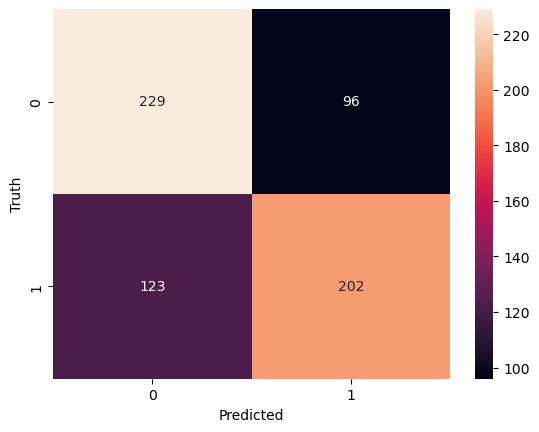

In [28]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

# Classification Report

In [29]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.65      0.70      0.68       325
           1       0.68      0.62      0.65       325

    accuracy                           0.66       650
   macro avg       0.66      0.66      0.66       650
weighted avg       0.66      0.66      0.66       650



# LET US TEST 

In [30]:
BLOG=["Most tools will let you convert a partition from one file type to another, i.e. from NTFS to FAT/FAT32 or vice versa. Needless to say that in most cases, such a conversion, especially from NTFS to FAT/FAT32 will cause the files to lose their NTFS permissions (ACLs), and in some cases where EFS was used to encrypt the files, it will actually cause you to lose access to these files. So beware!Some of these tools may be able to help you recover deleted partitions, and if data on that disk was un-damaged, actually help you gain access to that data. Some, but not all of the tools may have the ability to move existing partitions from one location on the disk to another location, again, without losing data."]
model.predict(BLOG)
if model.predict(BLOG)>0.5:
    print('Male')
    print(model.predict(BLOG))
else:
    print('Female')
    print(model.predict(BLOG))

1/1 [==============================] - 0s 270ms/step
Male
1/1 [==============================] - 0s 262ms/step
[[0.8054292]]
